<a href="https://colab.research.google.com/github/Rahulx911/grid-6.0/blob/main/object_count_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

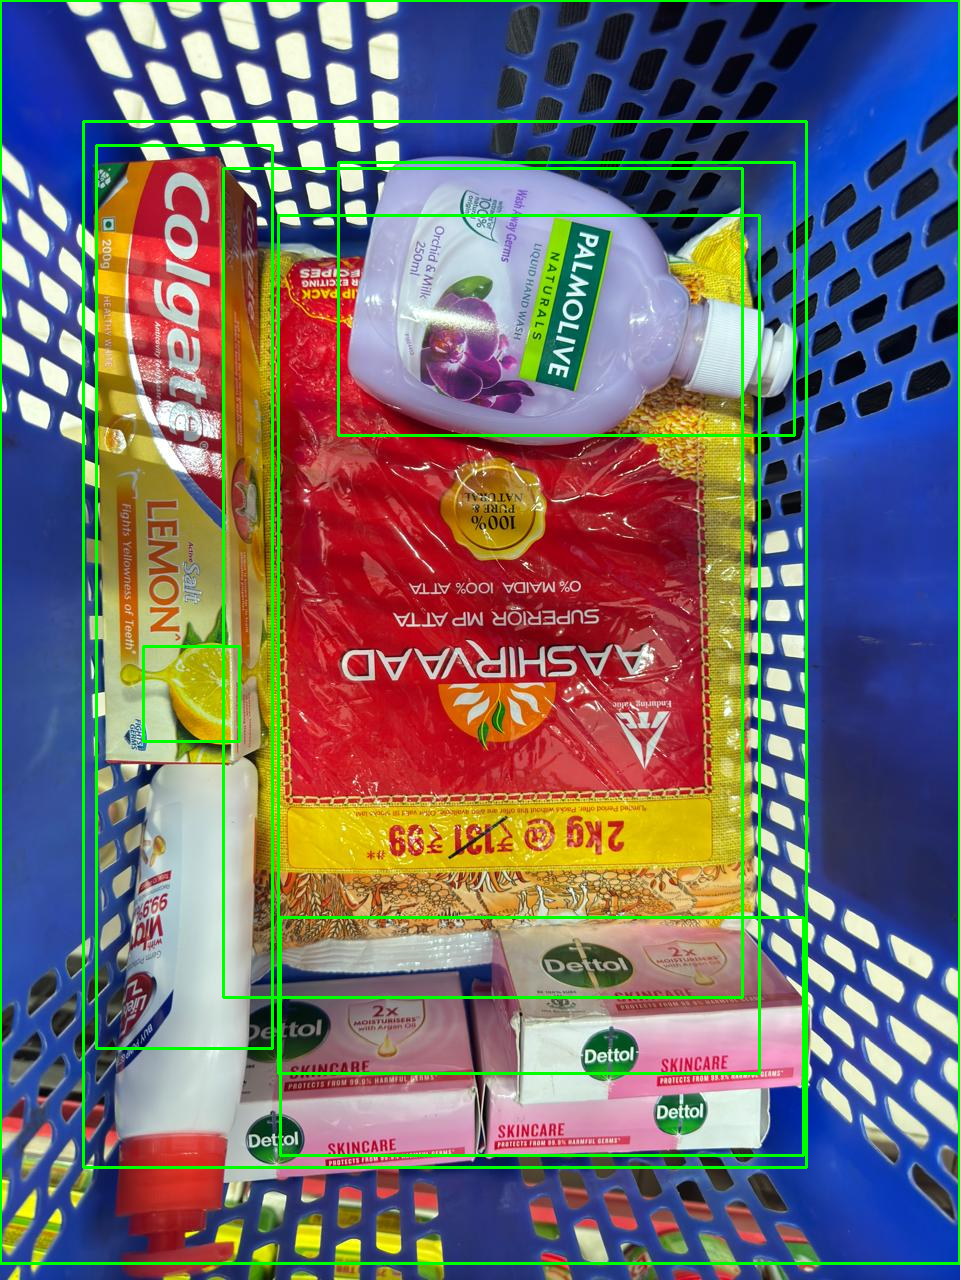

Total number of detected objects after applying Weighted Box Fusion: 8


In [12]:
!pip install ensemble-boxes # Install the 'ensemble-boxes' library
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, retinanet_resnet50_fpn
import cv2
import numpy as np
from torchvision.transforms import functional as F
from google.colab.patches import cv2_imshow
from ensemble_boxes import weighted_boxes_fusion  # Import WBF library

# List of pre-trained models from torchvision
models = [
    fasterrcnn_resnet50_fpn(pretrained=True).eval(),
    retinanet_resnet50_fpn(pretrained=True).eval()  # RetinaNet for diversity
]

# Load the image
img = cv2.imread("/content/test-img-2.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
img_tensor = F.to_tensor(img_rgb)  # Convert image to tensor

# Store all bounding boxes, scores, classes, and their respective model confidences
all_boxes = []
all_scores = []
all_classes = []
all_labels = []

# Confidence threshold to filter low-quality predictions
score_threshold = 0.2

# Run detection for each model
for model in models:
    with torch.no_grad():
        predictions = model([img_tensor])[0]  # Run model on the image tensor

    # Filter out low-confidence detections
    high_conf_idx = predictions['scores'] > score_threshold
    boxes = predictions['boxes'][high_conf_idx].cpu().numpy()
    scores = predictions['scores'][high_conf_idx].cpu().numpy()
    classes = predictions['labels'][high_conf_idx].cpu().numpy()

    # Normalize bounding boxes to [0, 1] for WBF
    height, width = img.shape[:2]
    norm_boxes = boxes / [width, height, width, height]

    # Store results for Weighted Box Fusion
    all_boxes.append(norm_boxes.tolist())
    all_scores.append(scores.tolist())
    all_classes.append(classes.tolist())
    all_labels.append(classes.tolist())

# Use Weighted Box Fusion to combine predictions from all models
iou_threshold = 0.35  # IoU threshold for box fusion
boxes_wbf, scores_wbf, labels_wbf = weighted_boxes_fusion(
    all_boxes, all_scores, all_labels, iou_thr=iou_threshold, skip_box_thr=score_threshold
)

# Denormalize boxes after WBF
boxes_wbf = np.array(boxes_wbf) * [width, height, width, height]

# Draw the final bounding boxes on the image
for box in boxes_wbf:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw green box

# Display the final image with bounding boxes and detected objects from both models
cv2_imshow(img)

print(f"Total number of detected objects after applying Weighted Box Fusion: {len(boxes_wbf)}")
